In [1]:
import NN_routines as nns

load image...
create macro dataset...


  0%|          | 0/8 [00:00<?, ?it/s]

transfer macro prediction...


  8%|▊         | 3/40 [00:00<00:01, 27.81it/s]

create micro dataset...


  0%|          | 0/40 [00:00<?, ?it/s]

create raw prediction...


100%|██████████| 40/40 [04:30<00:00,  6.76s/it]


floodfill...
total time taken for prediction: 277.22s


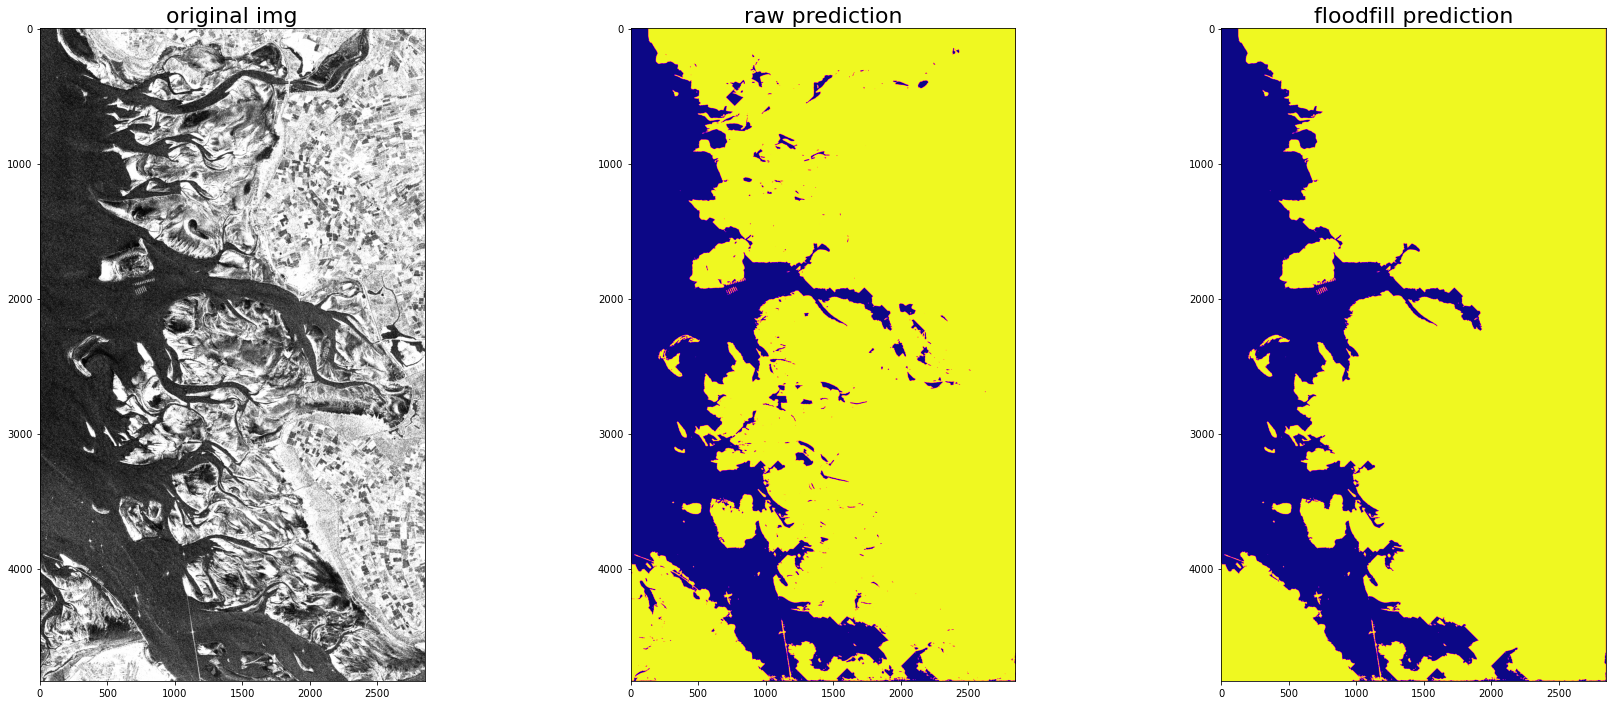

In [2]:
nns.predict_img('20200519',model_state = 'calm')

 12%|█▎        | 1/8 [00:00<00:01,  6.31it/s]

20200108   in process


 12%|█▎        | 1/8 [00:00<00:01,  5.69it/s]

20200414   in process


  0%|          | 0/100 [00:00<?, ?it/s]

macro training started
[INFO] total images: 136
[INFO] found 108 examples in the training set
[INFO] found 28 examples in the validation set
[INFO] training the network...


100%|██████████| 100/100 [15:25<00:00,  9.26s/it]



[INFO] total time taken to train the model: 925.60s
transfer started
20200108   in process


  0%|          | 0/8 [00:00<?, ?it/s]

20200414   in process


100%|██████████| 40/40 [00:02<00:00, 17.68it/s]


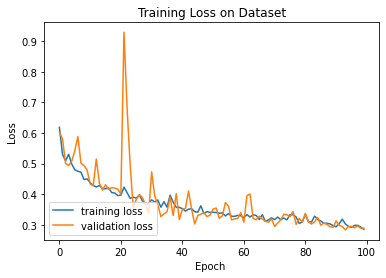

In [9]:
nns.training_dataset('Training_images/',aug = False,create_ds= True, macro_training = True,macro_epochs = 100,title = '100_e', micro_training = False,micro_epochs = 20,conv_layers = [[15,3],[15,3]])

load mask...
create macro dataset...


100%|██████████| 8/8 [00:01<00:00,  4.89it/s]


transfer macro prediction...
15


 12%|█▎        | 1/8 [00:00<00:01,  5.15it/s]

20200108   in process


  0%|          | 0/8 [00:00<?, ?it/s]

20200414   in process


  0%|          | 0/33 [00:00<?, ?it/s]

macro training started
[INFO] total images: 136
[INFO] found 108 examples in the training set
[INFO] found 28 examples in the validation set
[INFO] training the network...


  0%|          | 0/8 [00:00<?, ?it/s]


[INFO] total time taken to train the model: 295.58s
transfer started
20200108   in process


  0%|          | 0/8 [00:00<?, ?it/s]

20200414   in process


100%|██████████| 40/40 [00:02<00:00, 16.67it/s]


3


 12%|█▎        | 1/8 [00:00<00:01,  5.34it/s]

20200108   in process


  0%|          | 0/8 [00:00<?, ?it/s]

20200414   in process


  0%|          | 0/166 [00:00<?, ?it/s]

macro training started
[INFO] total images: 136
[INFO] found 108 examples in the training set
[INFO] found 28 examples in the validation set
[INFO] training the network...


  0%|          | 0/8 [00:00<?, ?it/s]


[INFO] total time taken to train the model: 526.06s
transfer started
20200108   in process


  0%|          | 0/8 [00:00<?, ?it/s]

20200414   in process


100%|██████████| 8/8 [00:02<00:00,  2.69it/s]


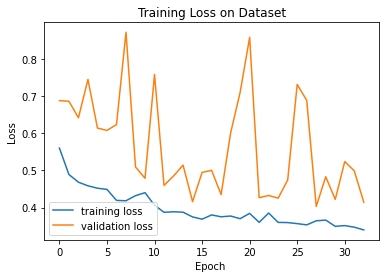

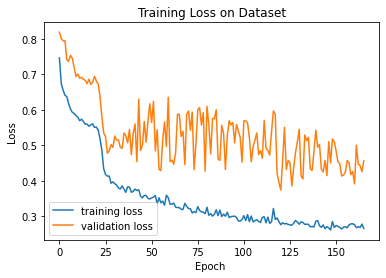

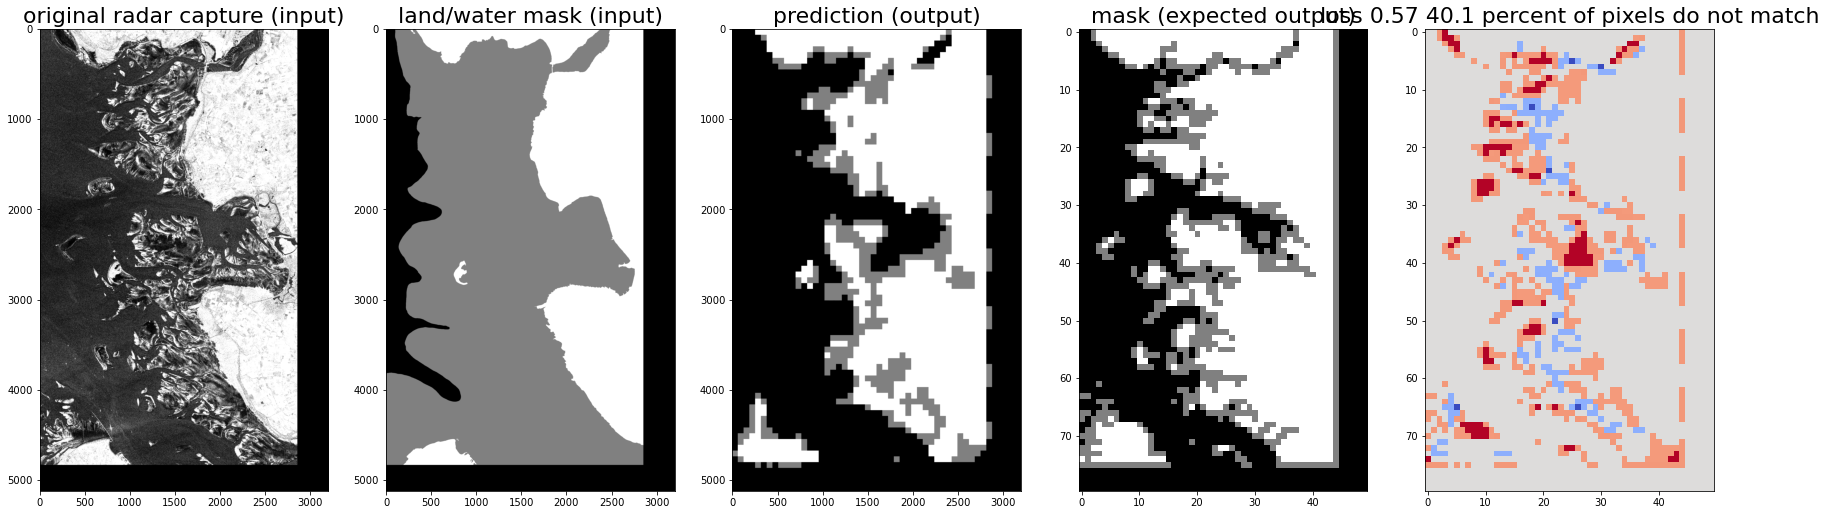

100%|██████████| 8/8 [00:02<00:00,  3.37it/s]


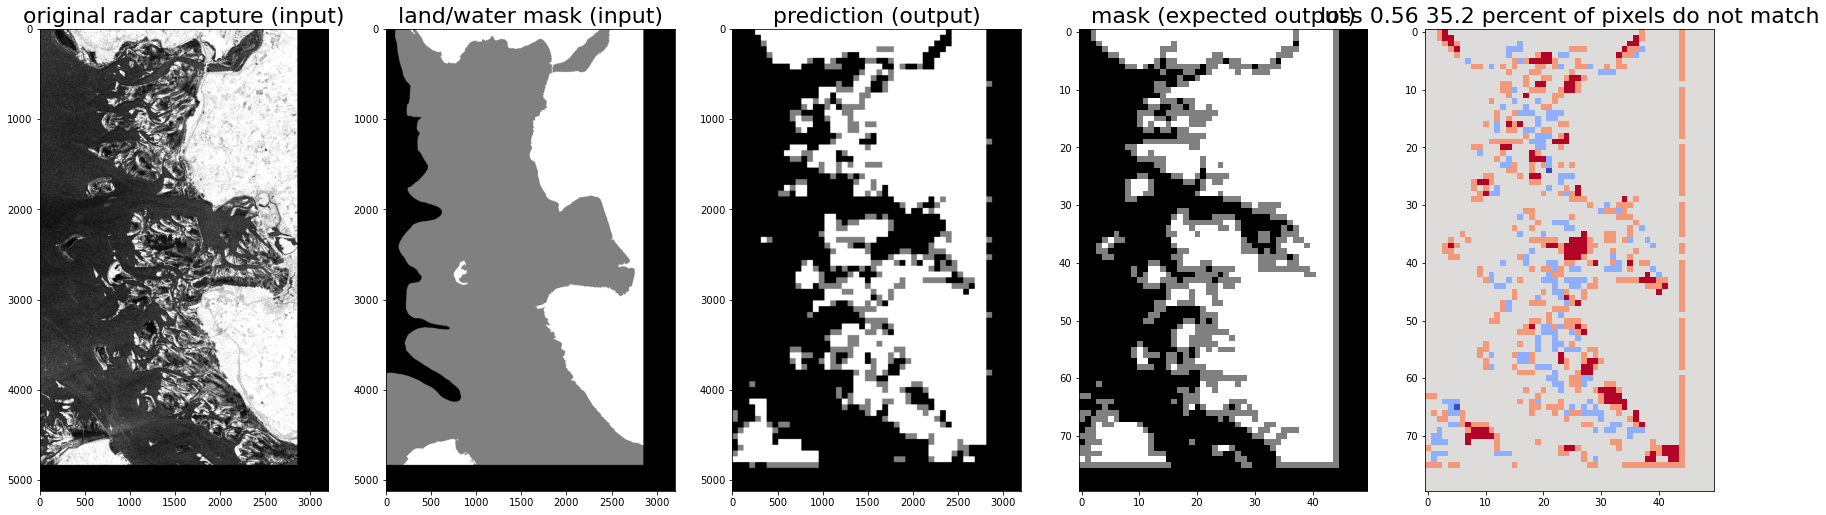

In [8]:
import torch
import cv2
import os
import matplotlib.pyplot as plt
name = '20200108'
img_path = 'Image_storage/image_'+name+'.png'
mask_path = 'Image_storage/mask_'+name+'.png'
lw_path='Supply/lw_mask.png'
model_state = 'test_small'

#micro_model_state = torch.load('Model_params/'+model_state+'_best.pt',map_location=torch.device('cpu'))                          # load model state if no training 
o_img = cv2.imread(img_path)
if os.path.exists(mask_path):
  print('load mask...')
  o_mask = cv2.imread(mask_path)  
  compare = True  
else: o_mask,compare = None,False
o_lw = cv2.imread(lw_path,0)
print('create macro dataset...')
img,mask = nns.image_process(o_img,o_mask)
nns.dataset_produce(img,mask,name,aug = False)
print('transfer macro prediction...')

for con in [15,3]:
    print(con)
    nns.training_dataset('Training_images/',aug = False,create_ds= True, macro_training = True,macro_epochs = 500//con,title = 'test_'+str(con), micro_training = False,micro_epochs = 20,conv_layers = [[con,3],[3,3]])
for con in [15,3]:    
    model_state = 'test_'+str(con)
    macro_model_state = torch.load('Model_params/'+model_state+'_macro_best.pt',map_location=torch.device('cpu'))                          # load model state if no training 
    nns.big_picture(macro_model_state,name,macro = True,thresh = 0.15,conv_layers = [[con,3],[3,3]],compare = True,show = True,out = False)
    plt.show()

In [6]:
nns.clear_routine([])

load image...
load mask...
create macro dataset...


100%|██████████| 8/8 [00:02<00:00,  3.39it/s]


total time taken for prediction: 5.10s


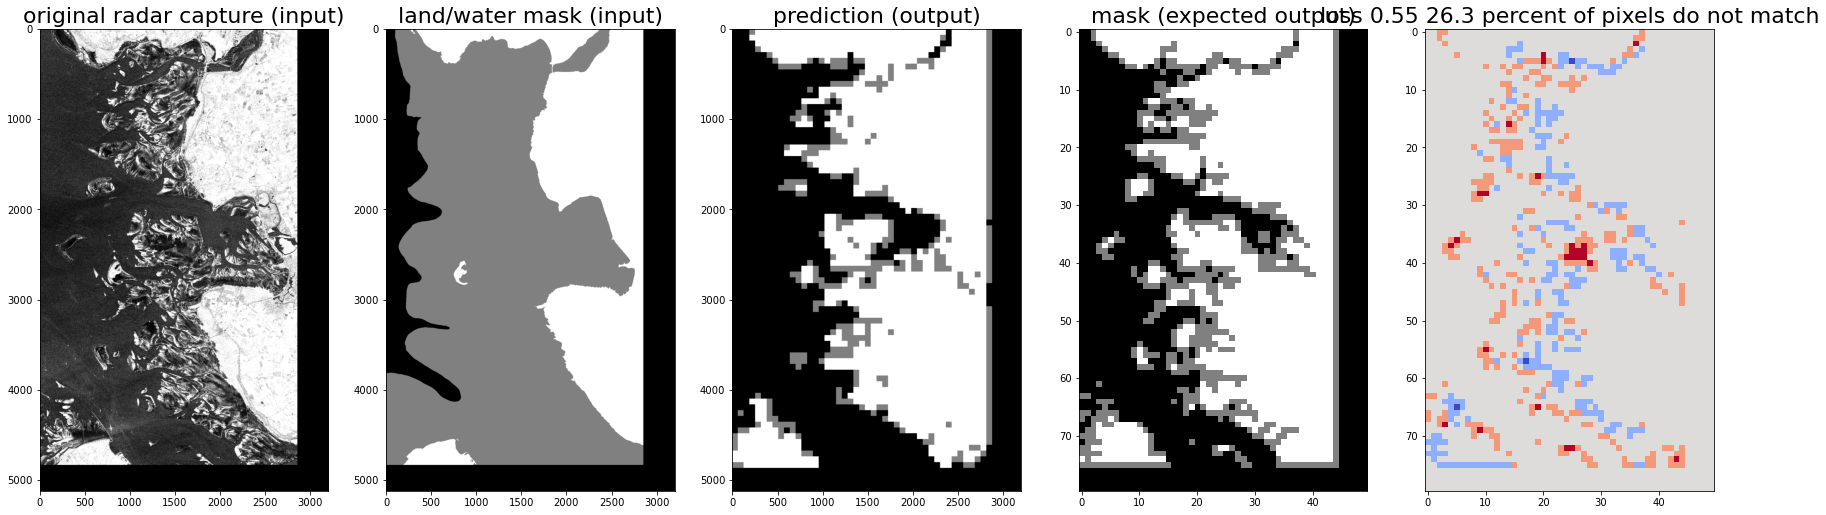

In [14]:
nns.predict_img('20200108',model_state = '100_e',only_macro = True,conv_layers = [[15,3],[15,3]])
nns.clear_routine([])

In [13]:
import os
for state in os.listdir('./Model_params'):
    print(state[-7])
    if state[-10:-5] == 'epoch':
        os.remove('Model_params/'+state)
    elif state[-11:-6] == 'epoch':
        os.remove('Model_params/'+state)
        #print(state[-11:-6])

b
b
b
0
t
_
b
b
b
b
a
b
